# **Convolutional Neural Network**

- MNIST 데이터
- 합성곱 연산 (CNN)
- 맥스풀링 (Max Pooling)
- 완전연결 신경망 (Fully Connected Network)

In [2]:
# 파이토치 및 토치 비전 설치
!pip install torch torchvision

## 1. 학습 전 세팅

### 1) 필요한 라이브러리 불러오기

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# 파이토치-torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 위해 용이하게 정리해놓음
# 데이터를 따로 학습에 맞게 정리하지 않아도 바로 사용 가능
import torchvision.datasets as dset

# torchvision.transforms - 이미지 데이터 자르거나 확대 등 이미지를 다양하게 변형시키는 함수들이 구현
import torchvision.transforms as transform

# DataLoader - 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

1.10.0+cu111


### 2) 하이퍼파라미터 지정

In [4]:
batch_size=256
learning_rate=0.0002
num_epoch=10

## 2. 데이터

### 1) 데이터 다운로드

In [5]:
# root: 데이터를 저장할 위치, train: 학습용 데이터인지 테스트용 데이터인지 여부
# transform: 이미지에 대한 변형, target_transform: 정답 라벨에 대한 변형
# transform.ToTensor(): 이미지나 Numpy 배열을 토치 텐서로 바꿔줌
# download: 데이터가 저장할 위치레 없을 경우 새로 다운받을지 여부

mnist_train=dset.MNIST(root="C:\\Users\\oh\\Desktop\\민지 대학\\휴먼프밍",train=True,transform=transform.ToTensor(),target_transform=None, download=True)
mnist_test=dset.MNIST(root="C:\\Users\\oh\\Desktop\\민지 대학\\휴먼프밍",train=False,transform=transform.ToTensor(),target_transform=None,download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw/train-images-idx3-ubyte.gz to C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw/train-labels-idx1-ubyte.gz to C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw/t10k-images-idx3-ubyte.gz to C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:\Users\oh\Desktop\민지 대학\휴먼프밍/MNIST/raw



### 2) 데이터셋 체크

- getitem/ 인덱싱으로 데이터 확인 가능

In [6]:
print(mnist_train.__getitem__(0)[0].size(),mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(),mnist_test.__len__())

print(len(mnist_train), len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


## 3) DataLoader 설정

- 사용할 데이터
- 배치 사이즈 (batch_size)
- 섞을지 여부 (shuffle)
- 사용할 프로세스 개수 (num_workers)
- 마지막에 남는 데이터의 처리 여부 (drop_last)

In [7]:
train_loader=DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

## 3. 모델, 손실함수, 최적화함수

### 1) CNN 모델

In [8]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    # 사용할 네트워크 모델 정의, forward() 함수에서 구현될 순전파를 layer 형태로 작성
    self.layer = nn.Sequential(
        # w = (w1-f+2p)/s+1
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5), # [batch_size,1,28,28] -> [batch_size,16,24,24]
        nn.ReLU(),
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5), # [batch_size,16,24,24] -> [batch_size,32,20,20]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2), # [batch_size,32,20,20] -> [batch_size,32,10,10]
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5), # [batch_size,32,10,10] -> [batch_size,64,6,6]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2) # [batch_size,64,6,6] -> [batch_size,64,3,3]
    )

    self.fc_layer=nn.Sequential(
        nn.Linear(64*3*3,100), # [batch_size,64,3,3] -> [batch_size,100]
        nn.ReLU(),
        nn.Linear(100,10) # [batch_size,100] -> [batch_size,10]
    )

  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1) # view 함수 -> 텐서의 형태를 [batch_size,나머지]로 바꿔줌.
    # ex) 2X3 형태의 텐서 view(1,-1) -> 1X6의 형태, view(3,-1) -> 3X2 형태
    # 전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류

    out=self.fc_layer(out)
    return out

## 2) 손실함수 & 최적화함수

In [9]:
# gpu 사용 가능 -> device를 gpu로 설정, 불가능하면 cpu로 설정
device=torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

model=CNN().to(device)

loss_func=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

## 4.학습

In [11]:
loss_arr=[]
for i in range(num_epoch):
  for j, [image,label] in enumerate(train_loader):
    x=image.to(device)
    y_=label.to(device)

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000 ==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy()) # gpu에 올라가 있는 tensor -> numpy/list로의 변환 필요
      # detach(): graph(연산기록)에서 분리한 새로운 tensor 반환
      # cpu(): gpu 메모리에 올려져 있는 tensor를 cpu 메모리로 복사
      # numpy(): tensor를 numpy로 변환; cpu 메모리에 올려져 있는 tensor만 numpy() method 사용 가능

      #https://byeongjo-kim.tistory.com/32

tensor(2.3082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1746, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0621, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward0>)


In [12]:
param_list=list(model.parameters())
print(param_list)

[Parameter containing:
tensor([[[[-0.1107, -0.2188, -0.1444, -0.0432,  0.2452],
          [-0.1710,  0.1626, -0.0867,  0.0446, -0.0418],
          [ 0.1349,  0.0350,  0.2309,  0.1528, -0.1187],
          [-0.0319,  0.1310, -0.1011, -0.1594, -0.1655],
          [ 0.0865,  0.0757, -0.1269,  0.0766,  0.0605]]],


        [[[ 0.2139,  0.0386,  0.2121,  0.1585, -0.0929],
          [-0.1888, -0.1337, -0.1132,  0.1883, -0.0682],
          [-0.1352, -0.0942, -0.0391, -0.1082,  0.1487],
          [ 0.1239,  0.1405, -0.1440,  0.2279,  0.0976],
          [-0.1405,  0.1295,  0.0545,  0.2610,  0.1335]]],


        [[[ 0.0512,  0.1302,  0.2339,  0.2743, -0.1039],
          [-0.0916,  0.0087,  0.0746,  0.1043,  0.0920],
          [-0.0855, -0.1533,  0.0265,  0.0870,  0.0418],
          [-0.1137, -0.2122, -0.1626, -0.0865,  0.0627],
          [ 0.0394, -0.0336,  0.0622, -0.1106,  0.2172]]],


        [[[-0.0879, -0.1904,  0.1264,  0.2276, -0.1398],
          [-0.0921, -0.0123,  0.2169, -0.0444,  0.078

## 5. 학습시 손실 시각화

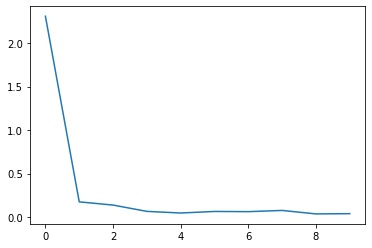

In [13]:
plt.plot(loss_arr)
plt.show()

## 6. 테스트 데이터 정확도 측정

In [18]:
correct=0 # 맞은 개수
total=0 # 전체 개수

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)

    output=model.forward(x)
    _,output_index=torch.max(output,1) # torch.max -> 최대 값 및 최대값 인덱스 뽑아내기

    total+=label.size(0) # 전체 개수는 라벨 개수로 더해줌.

    correct+=(output_index==y_).sum().float() 
    # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줌.

  print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 98.72796630859375%
